# Sentiment Analysis P3

In this notbook, you will learn how to build a deep LSTM network and how to insert a fixed pre-trained embedding layer in tensorflow Keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/Project\ 15\ NLP

/content/drive/MyDrive/Colab Notebooks/Project 15 NLP


In [ ]:
%ls

models/            __pycache__/  sentiment_analysis_p3.ipynb
nlp_proj_utils.py  resources/    testset/


<img src="resources/pipeline.png" width="800px">

In [ ]:
!pip install emoji wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import utils and set plt settings
import nlp_proj_utils as utils
import matplotlib.pyplot as plt
import numpy as np
import collections
import sklearn as sk
from numpy.random import choice

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
import tensorflow as tf
print(tf.__version__)
print("Number of available GPUs: ", tf.config.list_physical_devices("GPU"))

2.9.2
Number of available GPUs:  []


## Still Emoji

In [10]:
train_x, test_x, train_y, test_y = utils.load_emoji()

In [ ]:
print("Train: ", train_x.shape, train_y.shape)
print("Test: ", test_x.shape, test_y.shape)
print(train_x[0:3], train_y[0:3])
print(test_x[0:3], test_y[0:3])

Train:  (132,) (132,)
Test:  (56,) (56,)
['never talk to me again' 'I am proud of your achievements'
 'It is the worst day in my life'] [3 2 3]
['I want to eat\t' 'he did not answer\t' 'he got a very nice raise\t'] [4 3 2]


In [ ]:
# fix ending with \t
old_test_x = test_x
test_x = []
for i in old_test_x:
  test_x.append(str.replace(i,'\t',''))
test_x = np.array(test_x)

In [ ]:
print(test_x[0:3], test_y[0:3])

['I want to eat' 'he did not answer' 'he got a very nice raise'] [4 3 2]


In [ ]:
test_x[0:3]

array(['I want to eat', 'he did not answer', 'he got a very nice raise'],
      dtype='<U37')

In [ ]:
import emoji
print(emoji.emojize('Python is :thumbs_up:'))

Python is 👍


In [ ]:
# idx = 0
for idx in range(5):
  print(train_x[idx], ": ", utils.label_to_emoji(train_y[idx]))
  print(test_x[idx], ": ", utils.label_to_emoji(test_y[idx]))

never talk to me again :  😞
I want to eat :  🍴
I am proud of your achievements :  😄
he did not answer :  😞
It is the worst day in my life :  😞
he got a very nice raise :  😄
Miss you so much :  ❤️
she got me a nice present :  😄
food is life :  🍴
ha ha ha it was so funny :  😄


In [ ]:
counters = collections.Counter(train_y)
counters = sorted(counters.items(), key=lambda x: x[0])
counters

[(0, 22), (1, 19), (2, 38), (3, 36), (4, 17)]

In [ ]:
for label, count in counters:
    print("Label: {} -> Emoji: {}".format(label, utils.label_to_emoji(label)))

Label: 0 -> Emoji: ❤️
Label: 1 -> Emoji: ⚾
Label: 2 -> Emoji: 😄
Label: 3 -> Emoji: 😞
Label: 4 -> Emoji: 🍴


In [ ]:
counters = collections.Counter(train_y)
counters = sorted(counters.items(), key=lambda x: x[1], reverse=True)
counters

[(2, 38), (3, 36), (0, 22), (1, 19), (4, 17)]

In [ ]:
for label, count in counters:
    print("Label: {} -> Emoji: {}".format(label, utils.label_to_emoji(label)))

Label: 2 -> Emoji: 😄
Label: 3 -> Emoji: 😞
Label: 0 -> Emoji: ❤️
Label: 1 -> Emoji: ⚾
Label: 4 -> Emoji: 🍴


**Load pretrained word embeddings**

2 dictionaries are loaded:

- `word_to_index`: map a word to its index in the vocabulary
    - Example:  `'word' -> 1234`

- `word_to_vec_map`: map a word to its embedding
    - Example: `'word' -> [0.1, 0.2, ..., 0.45]`

When adding a custom embedding layer in Keras, we can only load the pretrained embedding as a big matrix instead of a dictionary. An index will help us locate the entry for a given word.

In [ ]:
# Google: Skip-gram, CBOW (first word2vec model)
# Stanford: Glove
# Facebook: FastText (Skip-gram/CBOW + Char-CNN)
word_to_index, word_to_vec = utils.load_glove_vecs()

data already available, skip downloading.
loading glove... this may take a while...
glove loaded successfully.


In [ ]:
print(len(word_to_index), len(word_to_vec))

400000 400000


In [ ]:
word = 'apple'
# word = 'car'
vector = word_to_vec[word]
print("Id: ", word_to_index[word])
print("Embedding: ", vector)
print("Embedding size: ", vector.shape)

Id:  57797
Embedding:  [ 0.52042  -0.8314    0.49961   1.2893    0.1151    0.057521 -1.3753
 -0.97313   0.18346   0.47672  -0.15112   0.35532   0.25912  -0.77857
  0.52181   0.47695  -1.4251    0.858     0.59821  -1.0903    0.33574
 -0.60891   0.41742   0.21569  -0.07417  -0.5822   -0.4502    0.17253
  0.16448  -0.38413   2.3283   -0.66682  -0.58181   0.74389   0.095015
 -0.47865  -0.84591   0.38704   0.23693  -1.5523    0.64802  -0.16521
 -1.4719   -0.16224   0.79857   0.97391   0.40027  -0.21912  -0.30938
  0.26581 ]
Embedding size:  (50,)


In [ ]:
print(word_to_vec[word])
print(word_to_vec[word].shape)
print(word_to_vec[word].reshape(1, -1))
print(word_to_vec[word].reshape(1, -1).shape)

[ 0.52042  -0.8314    0.49961   1.2893    0.1151    0.057521 -1.3753
 -0.97313   0.18346   0.47672  -0.15112   0.35532   0.25912  -0.77857
  0.52181   0.47695  -1.4251    0.858     0.59821  -1.0903    0.33574
 -0.60891   0.41742   0.21569  -0.07417  -0.5822   -0.4502    0.17253
  0.16448  -0.38413   2.3283   -0.66682  -0.58181   0.74389   0.095015
 -0.47865  -0.84591   0.38704   0.23693  -1.5523    0.64802  -0.16521
 -1.4719   -0.16224   0.79857   0.97391   0.40027  -0.21912  -0.30938
  0.26581 ]
(50,)
[[ 0.52042  -0.8314    0.49961   1.2893    0.1151    0.057521 -1.3753
  -0.97313   0.18346   0.47672  -0.15112   0.35532   0.25912  -0.77857
   0.52181   0.47695  -1.4251    0.858     0.59821  -1.0903    0.33574
  -0.60891   0.41742   0.21569  -0.07417  -0.5822   -0.4502    0.17253
   0.16448  -0.38413   2.3283   -0.66682  -0.58181   0.74389   0.095015
  -0.47865  -0.84591   0.38704   0.23693  -1.5523    0.64802  -0.16521
  -1.4719   -0.16224   0.79857   0.97391   0.40027  -0.21912  -0.3

In [ ]:
from sklearn import metrics

def cosine_similarity(word1, word2):
    vectorize = lambda word: word_to_vec[word].reshape(1, -1)
    return metrics.pairwise.cosine_similarity(vectorize(word1), vectorize(word2)).ravel()[0]

import math
def cosine_similarity_np(word1, word2):
    vec1 = word_to_vec[word1]
    vec2 = word_to_vec[word2]
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# v1=[1, 2] v2=[3, 6] ||v1||2 < ||v2||2  cosine(v1, v2) = 0


In [ ]:
print(cosine_similarity('engineer', 'engineering'))
print(cosine_similarity_np('engineer', 'engineering'))

0.69137562901875
0.6913756290187502


In [ ]:
cosine_similarity('engineer', 'engineer')

1.0

In [ ]:
cosine_similarity('engineer', 'banana')

0.008224793072062534

In [ ]:
cosine_similarity('apple', 'banana')

0.560792791926896

In [ ]:
cosine_similarity('apple', 'mac')

0.6521205282606707

In [ ]:
cosine_similarity('car', 'vehicle')

0.8833684148214744

### Max sequence length

In [ ]:
def sentences_to_indices(X, word_to_index, max_len, oov=0):
    """
    Return a array of indices of a given sentence. The sentence will be trimed/padded to max_len

    Args:
        X (np.ndarray): Input array of sentences, the shape is (m,)  where m is the number of sentences, each sentence is a str. 
        Example X: array(['Sentence 1', 'Setence 2'])
        word_to_index (dict[str->int]): map from a word to its index in vocabulary

    Return:
        indices (np.ndarray): the shape is (m, max_len) where m is the number of sentences
    """
    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    for i in range(m):
        sentence_words = X[i].lower().split()
        j = 0
        for w in sentence_words[:max_len]:
            X_indices[i, j] = word_to_index.get(w, oov)
            j = j + 1
    return X_indices

In [ ]:
MAX_SENTENCE_LEN = max([len(sentence.split()) for sentence in train_x])
print(MAX_SENTENCE_LEN)

10


In [ ]:
sentences_to_indices(np.array(['food is awesome']), word_to_index, max_len=MAX_SENTENCE_LEN)

array([[151204., 192973.,  64354.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.]])

In [ ]:
train_x_ids = sentences_to_indices(train_x, word_to_index, max_len=MAX_SENTENCE_LEN)
test_x_ids = sentences_to_indices(test_x, word_to_index, max_len=MAX_SENTENCE_LEN)

In [ ]:
print(train_x_ids.shape, '\n', test_x_ids.shape)

(132, 10) 
 (56, 10)


In [ ]:
train_x_ids[0:3]

array([[259914., 352214., 360915., 239105.,  47887.,      0.,      0.,
             0.,      0.,      0.],
       [185457.,  52943., 293982., 268046., 394565.,  45460.,      0.,
             0.,      0.,      0.],
       [193716., 192973., 357266., 390080., 117874., 188481., 254258.,
        222138.,      0.,      0.]])

In [ ]:
NUM_LABELS = 5
train_y_onehot = utils.convert_to_one_hot(train_y, NUM_LABELS)
test_y_onehot = utils.convert_to_one_hot(test_y, NUM_LABELS)
print(train_y_onehot[:3])
print(test_y_onehot[:3])

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]


In [ ]:
print(train_y_onehot.shape, test_y_onehot.shape)

(132, 5) (56, 5)


### Word Embeddings & One Hot

### Embedding Layer

We need to build a embedding matrix where each row represent a word vector.

In [ ]:
# Keras requires vocab length: 1 + actual vocab
# Index = 0 -> padding
vocab_len = 1 + len(word_to_index)
emb_dim = 50

# Create our embedding matrix
emb_matrix = np.zeros([vocab_len, emb_dim])
for word, index in word_to_index.items():
    emb_matrix[index, :] = word_to_vec[word]

In [ ]:
emb_matrix.shape

(400001, 50)

In [ ]:
emb_matrix[0:3]

array([[ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ],
       [-0.58402 ,  0.39031 ,  0.65282 , -0.3403  ,  0.19493 , -0.83489 ,
         0.11929 , -0.57291 , -0.56844 ,  0.72989 , -0.56975 ,  0.53436 ,
        -0.38034 ,  0.22471 ,  0.98031 , -0.2966  ,  0.126   ,  0.55222 ,
        -0.62737 , -0.082242, -0.085359,  0.31515 ,  0.96077 ,  0.31986 ,
         0.87878 , -1.5189  , -1.7831  ,  0.35639 ,  0.9674  , -1.5497  ,
       

In [ ]:
idx = 151204
emb_matrix[idx]

array([ 0.47222  , -0.44545  , -0.51833  , -0.26818  ,  0.44427  ,
       -0.25108  , -0.99282  , -0.90198  ,  1.8729   ,  0.039081 ,
        0.14284  ,  0.074878 ,  1.0543   , -0.3203   ,  1.0722   ,
        0.44323  ,  0.0099484,  0.15754  ,  0.51399  , -0.77668  ,
        0.924    ,  0.010958 ,  0.58815  ,  0.23078  , -0.34281  ,
       -0.88444  , -0.31492  ,  0.12661  ,  1.1445   ,  0.60775  ,
        3.4344   ,  0.63561  , -0.13832  ,  0.28045  , -0.16181  ,
        0.77541  , -0.49888  ,  0.4602   ,  0.91799  ,  0.29007  ,
        0.06884  ,  0.59978  ,  0.53967  , -0.061752 ,  1.2975   ,
        0.92323  , -0.80945  ,  0.34932  ,  0.33934  ,  0.25499  ])

In [ ]:
index_to_word = {v: k for k, v in word_to_index.items()}
word = index_to_word[idx]
print(word)
word_to_vec[word]

food


array([ 0.47222  , -0.44545  , -0.51833  , -0.26818  ,  0.44427  ,
       -0.25108  , -0.99282  , -0.90198  ,  1.8729   ,  0.039081 ,
        0.14284  ,  0.074878 ,  1.0543   , -0.3203   ,  1.0722   ,
        0.44323  ,  0.0099484,  0.15754  ,  0.51399  , -0.77668  ,
        0.924    ,  0.010958 ,  0.58815  ,  0.23078  , -0.34281  ,
       -0.88444  , -0.31492  ,  0.12661  ,  1.1445   ,  0.60775  ,
        3.4344   ,  0.63561  , -0.13832  ,  0.28045  , -0.16181  ,
        0.77541  , -0.49888  ,  0.4602   ,  0.91799  ,  0.29007  ,
        0.06884  ,  0.59978  ,  0.53967  , -0.061752 ,  1.2975   ,
        0.92323  , -0.80945  ,  0.34932  ,  0.33934  ,  0.25499  ])

For more information on how to define a pre-trained embedding layer in Keras, please refer to [this post](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).

### Build the Model - NB, LR, RF, GBT, XGBoost

In [ ]:
train_x[0:3], test_x[0:3]

(array(['never talk to me again', 'I am proud of your achievements',
        'It is the worst day in my life'], dtype='<U52'),
 array(['I want to eat', 'he did not answer', 'he got a very nice raise'],
       dtype='<U37'))

In [ ]:
train_y[0:3], test_y[0:3]

(array([3, 2, 3]), array([4, 3, 2]))

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(stop_words='english', lowercase=False)
train_features = tfidf_vec.fit_transform(train_x)
test_features = tfidf_vec.transform(test_x)

In [13]:
with open("models/test_features.pkl","wb") as f:
  pickle.dump(test_features,f)

In [ ]:
test_x[:5]

array(['I want to eat', 'he did not answer', 'he got a very nice raise',
       'she got me a nice present', 'ha ha ha it was so funny'],
      dtype='<U37')

#### NB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb_model = MultinomialNB()
mnb_model.fit(train_features, train_y)

pred = mnb_model.predict(test_features)
print('Accuracy: %f' % metrics.accuracy_score(pred, test_y))

Accuracy: 0.517857


In [ ]:
test_idx = choice(test_x_ids.shape[0])
pred = mnb_model.predict(test_features[test_idx])[0]
print("Naive Bayes")
print("Text: ",test_x[test_idx])
print("True Value: ", utils.label_to_emoji(test_y[test_idx]))
print("Prediction: ", utils.label_to_emoji(pred))

Naive Bayes
Text:  throw the ball
True Value:  ⚾
Prediction:  ⚾


In [ ]:
# customize input
your_words = 'so bad'
input = tfidf_vec.transform(np.array([your_words]))
pred = mnb_model.predict(input)[0]

print("Naive Bayes")
print("Text: ",your_words)
print("Prediction: ", utils.label_to_emoji(pred))

Naive Bayes
Text:  so bad
Prediction:  😞


#### LR

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(train_features, train_y)

pred = lr_model.predict(test_features)
print('Accuracy: %f' % metrics.accuracy_score(pred, test_y))

Accuracy: 0.625000


In [ ]:
test_idx = choice(test_x_ids.shape[0])
pred = lr_model.predict(test_features[test_idx])[0]
print("Logistic Regression")
print("Text: ",test_x[test_idx])
print("True Value: ", utils.label_to_emoji(test_y[test_idx]))
print("Prediction: ", utils.label_to_emoji(pred))

Logistic Regression
Text:  enjoy your game
True Value:  ⚾
Prediction:  ⚾


#### RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators = 1000)  #10, 100, 1000
rf_model.fit(train_features, train_y)

pred = rf_model.predict(test_features)
print('Accuracy: %f' % metrics.accuracy_score(pred, test_y))

Accuracy: 0.625000


In [ ]:
test_idx = choice(test_x_ids.shape[0])
pred = rf_model.predict(test_features[test_idx])[0]
print("Random Forest Classifier")
print("Text: ",test_x[test_idx])
print("True Value: ", utils.label_to_emoji(test_y[test_idx]))
print("Prediction: ", utils.label_to_emoji(pred))

Random Forest Classifier
Text:  where is the food
True Value:  🍴
Prediction:  🍴


#### GBC

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_model = GradientBoostingClassifier(n_estimators = 1000, verbose=1)  #10, 100, 1000
gbc_model.fit(train_features, train_y)

pred = gbc_model.predict(test_features)
print('Accuracy: %f' % metrics.accuracy_score(pred, test_y))

      Iter       Train Loss   Remaining Time 
         1           1.4293           10.18s
         2           1.3416            7.35s
         3           1.2770            6.45s
         4           1.2225            6.10s
         5           1.1760            5.84s
         6           1.1320            5.62s
         7           1.0932            5.50s
         8           1.0573            5.41s
         9           1.0206            5.36s
        10           0.9823            5.37s
        20           0.7461            4.96s
        30           0.5977            4.99s
        40           0.4902            4.77s
        50           0.4090            4.67s
        60           0.3446            4.55s
        70           0.2941            4.46s
        80           0.2523            4.35s
        90           0.2176            4.34s
       100           0.1892            4.25s
       200           0.0576            3.49s
       300           0.0254            2.94s
       40

In [ ]:
test_idx = choice(test_x_ids.shape[0])
pred = gbc_model.predict(test_features[test_idx])[0]
print("Gradient Boosting Classifier")
print("Text: ",test_x[test_idx])
print("True Value: ", utils.label_to_emoji(test_y[test_idx]))
print("Prediction: ", utils.label_to_emoji(pred))

Gradient Boosting Classifier
Text:  Let us go play baseball
True Value:  ⚾
Prediction:  ⚾


In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators = 10)
xgb_model.fit(train_features, train_y)

pred = xgb_model.predict(test_features)
print('Accuracy: %f' % metrics.accuracy_score(pred,test_y))

Accuracy: 0.482143


In [ ]:
test_idx = choice(test_x_ids.shape[0])
pred = xgb_model.predict(test_features[test_idx])[0]
print("XGBClassifier")
print("Text: ",test_x[test_idx])
print("True Value: ", utils.label_to_emoji(test_y[test_idx]))
print("Prediction: ", utils.label_to_emoji(pred))

XGBClassifier
Text:  throw the ball
True Value:  ⚾
Prediction:  😞


## save models

In [ ]:
# save all models above
import pickle

model_names = [
("model_mnb",mnb_model),
("model_lr" ,lr_model),
("model_rf" ,rf_model),
("model_gbc",gbc_model),
("model_xgb",xgb_model)
]

for name,model in model_names:
  with open(f'models/{name}.pkl','wb') as f:
    print(model)
    pickle.dump(model,f)

# "models/model_mnb.pkl"
# "models/model_lr.pkl"
# "models/model_rf.pkl"
# "models/model_gbc.pkl"
# "models/model_xgb.pkl"

MultinomialNB()
LogisticRegression()
RandomForestClassifier(n_estimators=1000)
GradientBoostingClassifier(n_estimators=1000, verbose=1)
XGBClassifier(n_estimators=10, objective='multi:softprob')


### Build the Model - LSTM

<img src="resources/deep_lstm.png" style="width:700px;height:400px;"> <br>
<caption><center> A 2-layer LSTM sequence classifier. </center></caption>

In [ ]:
from tensorflow.keras.layers import Input, Dropout, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [ ]:
Embedding??

In [ ]:
# Create embedding layer
# Transfer learning: Learn from a pretrained embedding model
# embedding = Embedding(
#     input_dim=emb_matrix.shape[0], # 400001
#     output_dim=emb_matrix.shape[1], # 50
#     weights=[emb_matrix],
#     trainable=False
# )

# 1. set trainable = False. freeze the pretrained embedding
# 2. set trainable = True. co-train the pretrained embedding with other layers (preferred)
# 3. Train embedding from scratch
embedding = Embedding(
    input_dim=emb_matrix.shape[0], # 400001
    output_dim=emb_matrix.shape[1], # 50
)

In [ ]:
print(train_x_ids.shape)
print(train_x_ids.shape[1:])
print(train_x_ids.dtype)

(132, 10)
(10,)
float64


In [ ]:
Dense??

In [ ]:
# Build the model
# train_x_ids: [# of examples, seq_length]
# Define the batch_size in training loop
input_ids = Input(shape=train_x_ids.shape[1:], dtype=train_x_ids.dtype)
input_embedding = embedding(input_ids)

# First LSTM layer
# out = LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)(input_embedding)
# # Second LSTM layer
# out = LSTM(units=128, return_sequences=False)(out)
# out = Dense(units=32, activation='sigmoid')(out)
# out = Dropout(rate=0.1)(out)
# out = Dense(NUM_LABELS, activation='softmax')(out)

# Only one LSTM layer, relu
out = LSTM(units=128, return_sequences=False, recurrent_dropout=0.1)(input_embedding)
out = Dense(units=32, activation='relu')(out)
out = Dropout(rate=0.1)(out)
out = Dense(NUM_LABELS, activation='softmax')(out)

## Only one LSTM layer, sigmoid
# out = LSTM(units=128, return_sequences=False, recurrent_dropout=0.1)(input_embedding)
# out = Dense(units=32, activation='sigmoid')(out)
# out = Dropout(rate=0.1)(out)
# out = Dense(NUM_LABELS, activation='softmax')(out)


model = Model(inputs=[input_ids], outputs=out, name='emoji_lstm')

In [ ]:
model.summary()

Model: "emoji_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 50)            20000050  
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 20,095,991
Trainable params: 20,095,991
No

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer='adam', metrics=['acc'])

In [ ]:
# opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=opt, metrics=['acc'])

In [ ]:
model

In [ ]:
from tensorflow.python.keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [ ]:
history = model.fit(
    x=train_x_ids,
    y=train_y_onehot,
    validation_data=(test_x_ids, test_y_onehot),
    batch_size=32, # 2^n
    epochs=100
)

Epoch 1/100
5/5 [==============================] - 5s 141ms/step - loss: 1.6087 - acc: 0.2197 - val_loss: 1.5966 - val_acc: 0.3214
Epoch 2/100
5/5 [==============================] - 0s 56ms/step - loss: 1.5999 - acc: 0.2727 - val_loss: 1.5900 - val_acc: 0.3214
Epoch 3/100
5/5 [==============================] - 0s 59ms/step - loss: 1.5934 - acc: 0.3712 - val_loss: 1.5811 - val_acc: 0.3214
Epoch 4/100
5/5 [==============================] - 0s 59ms/step - loss: 1.5872 - acc: 0.2803 - val_loss: 1.5699 - val_acc: 0.3214
Epoch 5/100
5/5 [==============================] - 0s 63ms/step - loss: 1.5718 - acc: 0.3182 - val_loss: 1.5527 - val_acc: 0.3214
Epoch 6/100
5/5 [==============================] - 0s 60ms/step - loss: 1.5461 - acc: 0.2879 - val_loss: 1.5291 - val_acc: 0.3214
Epoch 7/100
5/5 [==============================] - 0s 56ms/step - loss: 1.5066 - acc: 0.2955 - val_loss: 1.5044 - val_acc: 0.3214
Epoch 8/100
5/5 [==============================] - 0s 58ms/step - loss: 1.3913 - acc: 0.3

In [ ]:
def plot_history(history, metrics):
    for metric in metrics:
        plt.plot(history[metric], '-o', label=metric)
    plt.legend()
    plt.show()

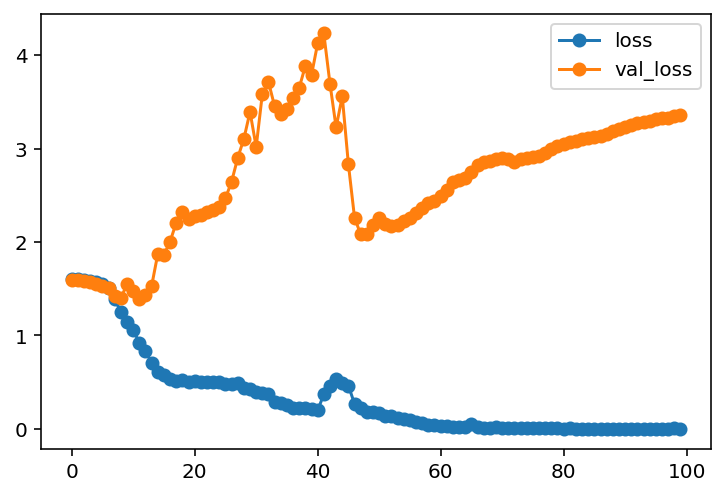

In [ ]:
plot_history(history.history, ['loss', 'val_loss'])

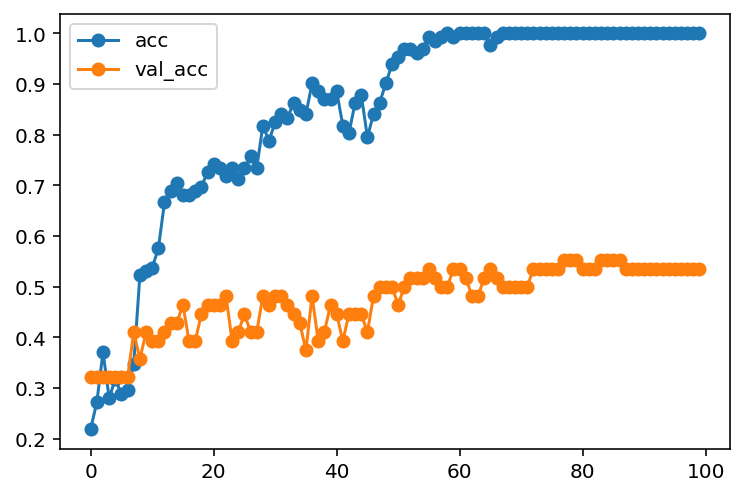

In [ ]:
plot_history(history.history, ['acc', 'val_acc'])

### Save and Load Models

Two parts need to be saved inorder to use the model in prod:

1. Neural Network Structure
2. Trained Weights (Matrix)

We will save them separately. This makes it easy to manage multiple versions of weights and you can always choose which version to go for production.

### Save model

In [ ]:
model_dir = 'models/emoji_lstm_glove_pretrain_freeze'

In [ ]:
model.save(model_dir)

In [ ]:
import os

In [ ]:
os.listdir(model_dir)

['variables', 'assets', 'keras_metadata.pb', 'saved_model.pb']

In [ ]:
os.listdir(model_dir + '/variables')

['variables.index', 'variables.data-00000-of-00001']

### Load model

In [ ]:
model_dir = 'models/emoji_lstm_glove_pretrain_freeze'
model_reload = tf.keras.models.load_model(model_dir)

### Inference / Prediction

In [ ]:
from numpy.random import choice
test_idx = choice(test_x_ids.shape[0])

probs = model_reload.predict(np.reshape(test_x_ids[test_idx], [1, -1])).ravel()
pred = np.argmax(probs)
print("LSTM")
print("Text: ",test_x[test_idx])
print("True Value: ", utils.label_to_emoji(test_y[test_idx]))
print("Prediction: ", utils.label_to_emoji(pred))

1/1 [==============================] - 0s 64ms/step
LSTM
Text:  he did not answer	
True Value:  😞
Prediction:  😞


In [ ]:
# save test sets
pickle.dump(test_y,open('testset/test_y.pkl','wb'))
pickle.dump(test_x_ids,open('testset/test_x_ids.pkl','wb'))

# test loads

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks/Project\ 15\ NLP

/content/drive/MyDrive/Colab Notebooks/Project 15 NLP


In [40]:
!pip list > google.txt

In [3]:
!pip install emoji wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 26.1 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=7184c0a24278ca546087471abd724ce10dda7afd240e4b257f81c871af8d1aa5
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=a01db2a9903ec866e3debb0fe55483ec0c1204d8491212098386306f962f6956
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built emoji wget


In [ ]:
# import utils and set plt settings
import nlp_proj_utils as utils
import numpy as np
import sklearn as sk
from numpy.random import choice
import pickle

# %matplotlib inline
# %config InlineBackend.figure_format='retina'

: 

In [5]:
#load test set x_ids,y,x_vectors
with open('testset/test_y.pkl','rb') as f:
  test_y = pickle.load(f)

with open('testset/test_x_ids.pkl','rb') as f:
  test_x_ids = pickle.load(f)

with open("models/test_features.pkl","rb") as f:
  test_features = pickle.load(f)

In [6]:
# load all models and lstm
model_names = [
"model_mnb",
"model_lr",
"model_rf",
"model_gbc",
"model_xgb",
]

models = []
for model in model_names:
  with open(f'models/{model}.pkl','rb') as f:
    models.append(pickle.load(f))

In [7]:
import tensorflow as tf
model_dir = 'models/emoji_lstm_glove_pretrain_freeze'
model_reload = tf.keras.models.load_model(model_dir)

In [38]:
# test set sample prediction
def lstm_pred(test_idx):
  probs = model_reload.predict(np.reshape(test_x_ids[test_idx], [1, -1]),verbose = 0).ravel()
  pred = np.argmax(probs)
  return pred

test_idx = choice(test_x_ids.shape[0])
print("Text: ",test_x[test_idx])
print("True Value: ", utils.label_to_emoji(test_y[test_idx]))
for i,model in enumerate(models):
  pred = model.predict(test_features[test_idx])[0]
  print(model_names[i])
  print("Prediction: ", utils.label_to_emoji(pred))

# lstm
print("lstm")
print("Prediction: ", utils.label_to_emoji(lstm_pred(test_idx)))

Text:  you brighten my day	
True Value:  😄
model_mnb
Prediction:  😞
model_lr
Prediction:  😞
model_rf
Prediction:  😞
model_gbc
Prediction:  🍴
model_xgb
Prediction:  😞
lstm
Prediction:  😞


In [ ]:
[utils.label_to_emoji(i) for i in range(5)]

['❤️', '⚾', '😄', '😞', '🍴']

In [17]:
def sentences_to_indices(X, word_to_index, max_len, oov=0):
    """
    Return a array of indices of a given sentence. The sentence will be trimed/padded to max_len

    Args:
        X (np.ndarray): Input array of sentences, the shape is (m,)  where m is the number of sentences, each sentence is a str. 
        Example X: array(['Sentence 1', 'Setence 2'])
        word_to_index (dict[str->int]): map from a word to its index in vocabulary

    Return:
        indices (np.ndarray): the shape is (m, max_len) where m is the number of sentences
    """
    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    for i in range(m):
        sentence_words = X[i].lower().split()
        j = 0
        for w in sentence_words[:max_len]:
            X_indices[i, j] = word_to_index.get(w, oov)
            j = j + 1
    return X_indices

word_to_index, word_to_vec = utils.load_glove_vecs()

data already available, skip downloading.
loading glove... this may take a while...
glove loaded successfully.


In [30]:
def lstm_pred_your_words(your_words):
  MAX_SENTENCE_LEN = 10
  your_words_id = sentences_to_indices(np.array([your_words]), word_to_index, max_len=MAX_SENTENCE_LEN)
  probs = model_reload.predict(np.reshape(your_words_id, [1, -1]),verbose = 0).ravel()
  pred = np.argmax(probs)
  return pred


print(f"{'models':+^30}")
[print(str(i)) for i in models]
print(str(model_reload))

print()
print(f"{'test_cases':+^30}")
your_words_test = ['bad day','good morning','i like you','nice ball','i need food']
labels = [3,2,0,1,4]
preds = []
for i,your_words in enumerate(your_words_test):
  preds = []
  print(f"{your_words:+^30}")
  print("Expected Value:", utils.label_to_emoji(labels[i]))
  for i,model in enumerate(models):
    input = tfidf_vec.transform(np.array([your_words]))
    pred = model.predict(input)[0]
    preds.append(pred)
    # print(model_names[i])
    # print("Prediction: ", utils.label_to_emoji(pred))

  # lstm
  # print("lstm")
  lstm_pred = lstm_pred_your_words(your_words)
  preds.append(lstm_pred)
  # print("Prediction: ", utils.label_to_emoji(lstm_pred))
  print([utils.label_to_emoji(i) for i in preds])

++++++++++++models++++++++++++
MultinomialNB()
LogisticRegression()
RandomForestClassifier(n_estimators=1000)
GradientBoostingClassifier(n_estimators=1000, verbose=1)
XGBClassifier(missing=nan, n_estimators=10, objective='multi:softprob')

++++++++++test_cases++++++++++
+++++++++++bad day++++++++++++
Expected Value: 😞
['😞', '😞', '😞', '😞', '😞', '😞']
+++++++++good morning+++++++++
Expected Value: 😄
['😄', '😞', '😞', '🍴', '😞', '😄']
++++++++++i like you++++++++++
Expected Value: ❤️
['😄', '😄', '❤️', '❤️', '😄', '❤️']
++++++++++nice ball+++++++++++
Expected Value: ⚾
['⚾', '⚾', '⚾', '⚾', '😞', '⚾']
+++++++++i need food++++++++++
Expected Value: 🍴
['🍴', '🍴', '🍴', '🍴', '🍴', '🍴']


In [35]:
import sys
print(sys.version)

3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]
